In [100]:
# multi layer perceptron to predict the next word in a sequence
# https://www.youtube.com/watch?v=TCH_1BHY58I
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [101]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
import numpy as np

words = open('names.txt', 'r').read().splitlines()
print(len(words))

# read in all the words
words = open("/kaggle/input/namestxt/names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [103]:
len(words)

32033

In [104]:
# build the vocabulary of characters and mappings to/from integers
characters = sorted(list(set("".join(words))))
stringToInt = {s:i + 1 for i, s in enumerate(characters)}
stringToInt["."] = 0
intToString = {i:s for s, i in stringToInt.items()}
print(intToString)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [105]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], [] # X input to the nueral net, Y label fo reach example in X

for w in words[:5]:
    print(w)
    # start with padded context of 0 ("." character)
    context = [0] * block_size
    for char in w + ".":
        intX = stringToInt[char]
        X.append(context)
        Y.append(intX)
        print("".join(intToString[i] for i in context), "--->", intToString[intX]) # examples we can generate
        context = context[1:] + [intX] # crop the context and enter the new character in the sequence (sliding window of context)

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [106]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [107]:
# create a lookup table
generator = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=generator) # two dimensional embeddings for each character
C[:1]

tensor([[ 1.5674, -0.2373]])

In [108]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [109]:
W1 = torch.randn((6, 100), generator=generator) # weights, 100 neurons
b1 = torch.randn(100, generator=generator) # bias

In [110]:
emb[:, 0, :] # plucks out 32 embeddings of just the first word

tensor([[ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [-0.4713,  0.7868],
        [ 2.4448, -0.6701],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [-1.0725,  0.7276],
        [-0.0707,  2.4968],
        [ 0.6772, -0.8404],
        [-0.1158, -1.2078],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 0.6772, -0.8404],
        [ 0.1476, -1.0006],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296],
        [-0.4713,  0.7868],
        [-0.0707,  2.4968],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 0.1476, -1.0006],
        [-1.0725,  0.7276],
        [ 0.0511,  1.3095],
        [ 1.5618, -1.6261]])

In [111]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1) # first 3 characters, makes it a [32.6] shape

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.0725,  0.7276],
        [ 1.5674, -0.2373, -1.0725,  0.7276, -0.0707,  2.4968],
        [-1.0725,  0.7276, -0.0707,  2.4968,  0.6772, -0.8404],
        [-0.0707,  2.4968,  0.6772, -0.8404, -0.1158, -1.2078],
        [ 0.6772, -0.8404, -0.1158, -1.2078,  0.6772, -0.8404],
        [-0.1158, -1.2078,  0.6772, -0.8404, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.0274, -1.1008],
        [ 1.5674, -0.2373, -0.0274, -1.1008, -0.1158, -1.2078],
        [-0.0274, -1.1008, -0.1158, -1.2

In [112]:
# instead of doing it manually use unbind
# removes a tensor dimension, returns a tuple of all slices along a given dimension without it

torch.cat(torch.unbind(emb, 1), 1)

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.0725,  0.7276],
        [ 1.5674, -0.2373, -1.0725,  0.7276, -0.0707,  2.4968],
        [-1.0725,  0.7276, -0.0707,  2.4968,  0.6772, -0.8404],
        [-0.0707,  2.4968,  0.6772, -0.8404, -0.1158, -1.2078],
        [ 0.6772, -0.8404, -0.1158, -1.2078,  0.6772, -0.8404],
        [-0.1158, -1.2078,  0.6772, -0.8404, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.0274, -1.1008],
        [ 1.5674, -0.2373, -0.0274, -1.1008, -0.1158, -1.2078],
        [-0.0274, -1.1008, -0.1158, -1.2

In [113]:
emb.view(32, 6) # gives us same result

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.0725,  0.7276],
        [ 1.5674, -0.2373, -1.0725,  0.7276, -0.0707,  2.4968],
        [-1.0725,  0.7276, -0.0707,  2.4968,  0.6772, -0.8404],
        [-0.0707,  2.4968,  0.6772, -0.8404, -0.1158, -1.2078],
        [ 0.6772, -0.8404, -0.1158, -1.2078,  0.6772, -0.8404],
        [-0.1158, -1.2078,  0.6772, -0.8404, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.0274, -1.1008],
        [ 1.5674, -0.2373, -0.0274, -1.1008, -0.1158, -1.2078],
        [-0.0274, -1.1008, -0.1158, -1.2

In [114]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # pytorch infers 32 if given -1

In [115]:
h.shape # 100 activations for 32 examples

torch.Size([32, 100])

In [116]:
h

tensor([[-0.9348,  1.0000,  0.9258,  ...,  0.9786, -0.1926,  0.9515],
        [ 0.2797,  0.9997,  0.7675,  ...,  0.9929,  0.9992,  0.9981],
        [-0.9960,  1.0000, -0.8694,  ..., -0.5159, -1.0000, -0.0069],
        ...,
        [-0.9996,  1.0000, -0.9273,  ..., -0.9999, -0.9974, -0.9970],
        [-0.9043,  1.0000,  0.9868,  ..., -0.7859, -0.4819,  0.9981],
        [-0.9048,  1.0000,  0.9553,  ...,  0.9866,  1.0000,  0.9907]])

In [117]:
W2 = torch.randn((100, 27), generator=generator) # 27 characters that come next
b2 = torch.randn(27)

In [118]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [119]:
counts = logits.exp() # simulate counts

In [120]:
# normalize counts, chance of choosing next character
probabilities = counts / counts.sum(1, keepdims=True) 
probabilities[:1]

tensor([[2.0749e-08, 3.5538e-08, 4.8128e-04, 9.0976e-10, 5.1686e-11, 2.2195e-13,
         3.1772e-16, 1.2769e-03, 3.0097e-08, 1.3413e-01, 8.6321e-01, 6.2879e-11,
         7.9085e-10, 9.8091e-10, 6.1926e-04, 4.7478e-09, 7.5692e-09, 6.0724e-06,
         1.3933e-05, 7.4684e-09, 7.2824e-11, 1.2883e-08, 1.1093e-11, 1.1041e-09,
         2.0436e-04, 3.5511e-08, 5.2833e-05]])

In [121]:
probabilities[0].sum() # each row should sum to 1

tensor(1.)

In [122]:
# current probablity to the correct character in a sequence
# want probablities as close to 1 as possible
probabilities[torch.arange(32), Y]

tensor([2.2195e-13, 6.6510e-12, 1.0855e-07, 8.5333e-09, 4.1862e-11, 4.7478e-09,
        8.2539e-14, 7.0734e-10, 3.7505e-09, 3.4687e-04, 4.3465e-06, 5.2187e-04,
        3.5538e-08, 7.9574e-11, 6.8559e-05, 1.8456e-06, 1.3413e-01, 2.6268e-08,
        3.5393e-07, 5.4182e-02, 2.5385e-04, 1.2558e-11, 4.9143e-10, 1.8525e-14,
        1.1258e-02, 7.4684e-09, 1.5356e-03, 6.0022e-05, 2.9868e-10, 7.1444e-01,
        2.4913e-08, 1.7351e-11])

In [123]:
# calculate loss
loss = -probabilities[torch.arange(32), Y].log().mean()
loss

tensor(16.3073)

In [124]:
# ---- summary view ----

In [125]:
C = torch.randn((27, 2), generator=generator) # two dimension embedding for each character
W1 = torch.randn((6, 100), generator=generator) # 100 neurons
b1 = torch.randn(100, generator=generator)
W2 = torch.randn((100, 27), generator=generator)
b2 = torch.randn(27, generator=generator)
parameters = [C, W1, b1, W2, b2]

# sum of parameters
sum(p.nelement() for p in parameters)

3481

In [126]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y) # calculate more efficiently with PyTorch
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

    

0.2556919455528259


In [127]:
# easy to overfit due to small sample size

In [128]:
# build the dataset with all words

block_size = 3 # context length: how many characters do we take to predict the next one? 
X, Y = [], [] # X input to the nueral net, Y label for each example in X
for w in words:
    # start with padded context of 0 ("." character)
    context = [0] * block_size
    for char in w + ".":
        intX = stringToInt[char]
        X.append(context)
        Y.append(intX)
        context = context[1:] + [intX] # crop the context and enter the new character in the sequence (sliding window of context)
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [129]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [130]:
# reinitialize
C = torch.randn((27, 2), generator=generator)
W1 = torch.randn((6, 100), generator=generator)
b1 = torch.randn(100, generator=generator)
W2 = torch.randn((100, 27), generator=generator)
b2 = torch.randn(27, generator=generator)
parameters = [C, W1, b1, W2, b2]

In [131]:
for p in parameters:
    p.requires_grad = True
    
for _ in range(10):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y) # calculate more efficiently with PyTorch
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

# takes too long per pass
# instead do it in batches

17.458772659301758
16.07534408569336
14.925856590270996
13.896233558654785
12.987191200256348
12.18989086151123
11.539338111877441
11.00778865814209
10.539271354675293
10.118026733398438


In [132]:
# reinitialize
C = torch.randn((27, 2), generator=generator)
W1 = torch.randn((6, 100), generator=generator)
b1 = torch.randn(100, generator=generator)
W2 = torch.randn((100, 27), generator=generator)
b2 = torch.randn(27, generator=generator)
parameters = [C, W1, b1, W2, b2]

In [133]:
for p in parameters:
    p.requires_grad = True
    
for _ in range(1000):
    # mini random batch construction
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2) only taking 32 rows, not 200k+
    
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix]) # calculate more efficiently with PyTorch

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
        
print(loss.item())

    
# almost instant compared to above
# quality of gradient is lower, direction not as reliable
# good enough that is lowers loss

2.856891393661499


In [134]:
# calculate loss for whole dataset
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.672415018081665


In [135]:
# determine a reliable learning rate
# if loss is barely decreasing learning rate too low
# if loss goes up and down rate too high

In [136]:
 # use a learning rate between 0.001 and 1 spaced exponentially
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs[:10]

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011])

In [137]:
# reinitialize
C = torch.randn((27, 2), generator=generator)
W1 = torch.randn((6, 100), generator=generator)
b1 = torch.randn(100, generator=generator)
W2 = torch.randn((100, 27), generator=generator)
b2 = torch.randn(27, generator=generator)
parameters = [C, W1, b1, W2, b2]

In [138]:
lri = []
lossi = []

for p in parameters:
    p.requires_grad = True
    
for i in range(1000):
    # mini random batch construction
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2) only taking 32 rows, not 200k+
    
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix]) # calculate more efficiently with PyTorch

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
        
print(loss.item())

11.950146675109863


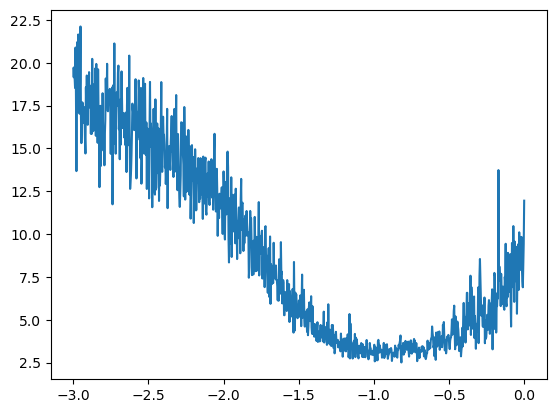

In [139]:
# unstability as we increase learning rate. Best learning rate between -1 and -0.5 (.1 and .05)
plt.plot(lri, lossi)

In [140]:
# reinitialize
C = torch.randn((27, 2), generator=generator)
W1 = torch.randn((6, 100), generator=generator)
b1 = torch.randn(100, generator=generator)
W2 = torch.randn((100, 27), generator=generator)
b2 = torch.randn(27, generator=generator)
parameters = [C, W1, b1, W2, b2]

In [141]:
# crank up iterations now that we have a good learning rate
for p in parameters:
    p.requires_grad = True
    
for _ in range(10000):
    # mini random batch construction
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2) only taking 32 rows, not 200k+
    
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix]) # calculate more efficiently with PyTorch

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
    
print(loss.item())

2.4758429527282715


In [142]:
# low loss can be a sign of overtraining if all data was used for training
# Should split data into training, validation and test split (80%, 10%, 10%)
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for char in w + ".":
            intX = stringToInt[char]
            X.append(context)
            Y.append(intX)
            context = context[1:] + [intX] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words)) # 80%
n2 = int(0.9 * len(words)) # 90%

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [143]:
# dataset
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [144]:
# reinitialize
C = torch.randn((27, 2), generator=generator)
W1 = torch.randn((6, 100), generator=generator)
b1 = torch.randn(100, generator=generator)
W2 = torch.randn((100, 27), generator=generator)
b2 = torch.randn(27, generator=generator)
parameters = [C, W1, b1, W2, b2]

In [145]:
# use only the training data
for p in parameters:
    p.requires_grad = True
    
for _ in range(10000):
    # mini random batch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2) only taking 32 rows, not 200k+
    
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix]) # calculate more efficiently with PyTorch

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
    
print(loss.item())

2.3948357105255127


In [146]:
# evaluate with the dev set
# loss is good with data that hasn't been trained
# roughly equal train loss and dev loss meaning we are not overfit
# network is very tiny, performance improvments could happen by scaling up size of neural net
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4662, grad_fn=<NllLossBackward0>)

In [147]:
# possible performance improvments
# use 300 neurons instead of 100
# increase number of dimenson embeddings per word

In [148]:
# 10 dimension embeddings. 3 * 10 or 30 inputs into hidden layer
# 300 neurons
# reinitialize
C = torch.randn((27, 10), generator=generator)
W1 = torch.randn((30, 300), generator=generator)
b1 = torch.randn(300, generator=generator)
W2 = torch.randn((300, 27), generator=generator)
b2 = torch.randn(27, generator=generator)
parameters = [C, W1, b1, W2, b2]


In [149]:
# total params
sum(p.nelement() for p in parameters)

17697

In [150]:
for p in parameters:
    p.requires_grad = True
    
# try decreasing the learning rate after 10000 iterations
for i in range(20000):
    # mini random batch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2) only taking 32 rows, not 200k+
    
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 300)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix]) # calculate more efficiently with PyTorch
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
print(loss.item())

2.8754303455352783


In [151]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4797, grad_fn=<NllLossBackward0>)

In [152]:
# generate samples from model

for i in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        intX = torch.multinomial(probs, num_samples=1, generator=generator).item()
        context = context[1:] + [intX]
        out.append(intX)
        if intX == 0:
            break
            
    print("".join(intToString[i] for i in out))

rayca.
annaryi.
ahydah.
yamil.
zhynn.
taufhamafian.
nah.
anue.
nomirina.
antrichanihianashairel.
shanisa.
dardersin.
aasumiah.
gashyrenlyishyurialyne.
annyarnali.
dunemiriswaidurthey.
jami.
gorecera.
bryonir.
mayconnana.
